In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
%matplotlib inline
import time

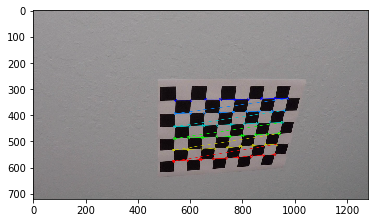

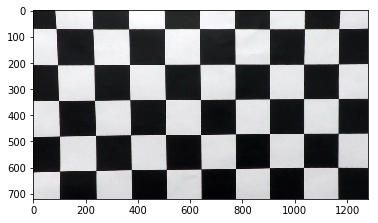

In [7]:
# Step 1 - Camera calibration Using Known Commands

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
obj3d = np.zeros((6*9,3), np.float32)
obj3d[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj3dpoints = [] # 3d points in real world space
img2dpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        obj3dpoints.append(obj3d)
        img2dpoints.append(corners)        

img_size = (img.shape[1], img.shape[0])
# Use object and image points to calculate camera distortion matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj3dpoints, img2dpoints, img_size,None,None)

#Example of finding chessboard corners
img1 = cv2.imread('camera_cal/calibration10.jpg')
gr = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret1, corners1 = cv2.findChessboardCorners(gr, (9,6), None)
cv2.drawChessboardCorners(img1,(9,6),corners1,ret1)
plt.imshow(img1)
plt.savefig('camera_cal_results/found_corners.png')

#Example of Undistored image
img2 = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img2, mtx, dist, None, mtx)
plt.show()
plt.imshow(dst)
plt.savefig('camera_cal_results/undistorted.png')


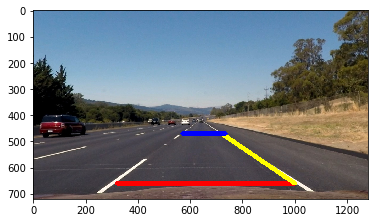

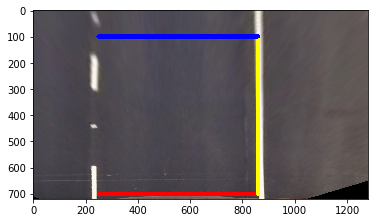

In [8]:
# Step 2 - Camera perspective shift Using Known Lesson Methods

img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = cv2.undistort(img, mtx, dist, None, mtx)

# Define source points
src = np.float32([[320,660],[1000,660],[720,470],[570,470]])
# Define destination points
dst = np.float32([[250,700],[860,700],[860,100],[250,100]])
# Use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# # # Use cv2.warpPerspective() to warp your image to a top-down view
img_size = (image.shape[1], image.shape[0])
warped = cv2.warpPerspective(image, M, img_size); 
# unwarped = cv2.warpPerspective(warped, Minv, img_size);

cv2.line(image,(320,660),(1000,660),(255,0,0),15)
cv2.line(image,(1000,660),(720,470),(255,255,0),15)
cv2.line(image,(735,470),(570,470),(0,0,255,0),15)

cv2.line(warped,(250,700),(860,700),(255,0,0),15)
cv2.line(warped,(860,700),(860,100),(255,255,0),15)
cv2.line(warped,(860,100),(250,100),(0,0,255,0),15)
img_shape = warped.shape;
#print(img_shape[0]-1)

plt.imshow(image)
plt.savefig('camera_cal_results/perspective_road.png')
plt.show()
plt.imshow(warped)
plt.savefig('camera_cal_results/warped_road.png')


In [4]:
class Line:
    
    
    # initialize class of self. Made to clean up code
    def __init__(self):
        self.imageNum = 0
        self.ploty = np.linspace(0, 719, 720)
        self.y_eval = np.max(self.ploty)        
        self.margin = 60
        self.last_updateL = 0
        self.last_updateR = 0
        self.left_fit = [0,0,0]
        self.right_fit = [0,0,0]
        self.diff1 = []
        self.diff2 = []
        self.right_curve = 0
        self.left_curve = 0
        self.right_update = 0
        self.left_update = 0
        self.text1 = ''
        self.text2 = ''
        self.total_curve = 0
        self.total_offset = 0
        
    # undistort image
    def undist(self, img):
        udst = cv2.undistort(img, mtx, dist, None, mtx)
        return udst

    # threshold picture
    def threshold(self, image):

        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        l_channel = hls[:,:,1]
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobel_x = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))

        # Threshold x gradient
        s_x_binary = np.zeros_like(scaled_sobel)
        s_x_binary[(scaled_sobel >= 30) & (scaled_sobel <= 100)] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= 180) & (s_channel <= 255)] = 1
        # Stack channels
        color_binary = 255*cv2.bitwise_or(s_binary,s_x_binary)  

        return color_binary    
    
     # method to calculate curvature.
    def calc_curvature(self):

        ym_per_pix = 30.0/725 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        x = [xm_per_pix*i for i in self.x]
        y = [ym_per_pix*i for i in self.y]

        fit = np.polyfit(y, x, 2)

        y_eval = self.y_eval*ym_per_pix
        # Implement the calculation of R_curve (radius of curvature) 
        curve_rad = (1 + (2*fit[0]*y_eval + fit[1])**2)**(3/2)/np.abs(2*fit[0])
       
        return curve_rad

    # fit lines using histogram and sliding windows
    def fit_lines_scratch(self, warped, side):
                
        # find bottom of lane
        bottom = warped[warped.shape[0]//2:,:]
        histogram = np.sum(bottom, axis=0)
        out_img = np.dstack((warped, warped, warped))

        mid_point = np.int(histogram.shape[0]//2)
        
        if (side):
            x_base = np.argmax(histogram[:mid_point])
        else:
            x_base = np.argmax(histogram[mid_point:]) + mid_point

        # Choose the number of sliding windows
        n_windows = 9
        # Set minimum number of pixels 
        min_pix = 50

        # Height of windows 
        window_height = np.int(warped.shape[0]//n_windows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions for each window in n_windows
        x_current = x_base

        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(n_windows):
            # Identify window boundaries in x and y
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            # Find the four below boundaries of the window ###
            win_x_low = x_current - self.margin 
            win_x_high = x_current + self.margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),
            (win_x_high,win_y_high),(0,255,0), 4) 

            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzerox >= win_x_low) & (nonzerox <= win_x_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            if len(good_inds) > min_pix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Combine the arrays of indices
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        # calculate average residual value
        self.x = x
        self.y = y
        fit, res, _, _, _ = np.polyfit(y,x, 2, full=True)

        return fit,res/len(x)
    
    # fit lines using windows based on previous fit
    def fit_lines_from_previous(self,warped, fit):
        
        # Grab activated pixels
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])   
        
        # Grab pixel indeces within window boundaries
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + 
                        fit[2] - self.margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + 
                        fit[1]*nonzeroy + fit[2] + self.margin)))

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
             
        # calculate average residual value (if there is a fit)
        if ((len(x) > 0) and (len(y) > 0)):
            self.x = x
            self.y = y
            fit, res, _, _, _ = np.polyfit(y, x, 2, full=True)
            return fit, res/len(x)
        else:
            return [],3e10
        
    # draw a polygon filling in the lane and warp the perspective back to the original
    def fill_lane_color(self, left_fit, right_fit, warped, color):
    
        # create two lines using the fits
        left_fit_x = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
        right_fit_x = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]

        # make a 3 channel image
        out_img = np.dstack((warped, warped, warped))*255
        window_img = np.zeros_like(out_img)
        
        # create x y arrays
        left_line_window = np.array([np.transpose(np.vstack([left_fit_x, self.ploty]))])
        right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fit_x,self.ploty])))])
        line_pts = np.hstack((left_line_window, right_line_window))
        
        # draw polygon
        cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0)) 
        
        # warp back to original perspective
        unwarped = cv2.warpPerspective(window_img, Minv, img_size); 
        return unwarped
    
    def process_image(self, image):
                     
        # undistort image using distortion found in Step 1
        udst = self.undist(image)
        
        # threshold image by color
        thr = self.threshold(udst)
        
        # warp perspective to overhead
        warped = cv2.warpPerspective(thr, M, img_size); 

        color = 0
    
        # Fit lines from scratch on based on the previous image.
        if (self.imageNum > 1):
            right_fit, res = self.fit_lines_scratch(warped,0)
            if (res > 200 or res < 60):
                right_fit, res = self.fit_lines_from_previous(warped, self.right_fit)

            if (res < 200 and res > 60):
                # average the current polyfit with the latest polyfit
                self.right_fit = [.5*(i+j) for i,j in zip(right_fit, self.right_fit)]
        else:
            self.right_fit, res = self.fit_lines_scratch(warped,0)
        right_curve = self.calc_curvature()
        
        # Same for left lane line. decisions for lane lines are made separately
        if (self.imageNum > 1):
            left_fit, res = self.fit_lines_scratch(warped,1)
            if (res > 200 or res < 60):
                left_fit, res = self.fit_lines_from_previous(warped, self.left_fit)
                color = color + 1

            if (res < 200 and res > 60):
                self.left_fit = [.5*(i+j) for i,j in zip(left_fit, self.left_fit)]
                color = color + 1
        else:
            self.left_fit, res = self.fit_lines_scratch(warped,1)
        left_curve = self.calc_curvature()
              
        # fill polygon between polyfit lines and warp back to original perspective
        poly_Img = self.fill_lane_color(self.left_fit, self.right_fit, warped, color)
        
        # sum images for final result
        result = cv2.addWeighted(poly_Img, .3, udst, 1, 0)
        
        # display curvature and center information on image
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        curv = (left_curve + right_curve)/2
        self.total_curve = self.total_curve + curv
        xm_per_pix = 3.7/610 # meters per pixel in x dimension  
        lx = self.left_fit[0]*self.y_eval**2 + self.left_fit[1]*self.y_eval + self.left_fit[2]
        rx = self.right_fit[0]*self.y_eval**2 + self.right_fit[1]*self.y_eval + self.right_fit[2]
        offset = ((lx+rx)/2 - 555)*xm_per_pix
        self.total_offset = self.total_offset + offset
    
        if (self.imageNum % 20 == 19):
        # calculate average curvature
            curv = self.total_curve/20
            offset = self.total_offset/20
            self.text1 = "Curvature: " + str(int(curv)) + "m"
            self.text2 = ("Center Offset: {0:.2f}m".format(offset))
#             self.text2 = "center offset: " + str(int(offset)) + "m"
            self.total_curve = 0
            self.total_offset = 0
        cv2.putText(result, self.text1, (75, 50), font, 1, (0,0,0), 2, 8)
        cv2.putText(result, self.text2, (75, 100), font, 1, (0,0,0), 2, 8)
                   
        self.imageNum = self.imageNum + 1

        return result

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_output.mp4'
line = Line()

clip1 = VideoFileClip("project_video.mp4")#.subclip(0,.5)
res = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
res.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [06:04<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



In [6]:
x = 0.3855773
text = ("center offset: {0:.2f}m".format(x))
print(text)


center offset: 0.39m
